In [2]:
import pymongo
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
uri = "mongodb+srv://" + urllib.parse.quote("user") + ":" + urllib.parse.quote("Pizza.network1") + "@dentries-nsb6p.mongodb.net/test?retryWrites=true&w=majority"
client = pymongo.MongoClient(uri)
db = client.diary_entries_db

In [3]:
db.list_collection_names()

['diary_entries']

In [4]:
collection = db['diary_entries']

In [5]:
df = pd.DataFrame(list(collection.find()))

In [36]:
df.to_csv('entries.csv')

In [6]:
df.head()

,_id,title,date,startTime,endTime,content
0,5d2eb7761c9d440000d5bbfe,11-9-2017,11/9/2017,1:56 AM,2:10 AM,"Hello. How should I start? Umm..., well I am m..."
1,5d2eba9f1c9d440000d5bc01,11-11-2017,11/11/2017,1:20 AM,1:43 AM,"Ok, so new plan. I just sleep after I take my ..."
2,5d2ebbe91c9d440000d5bc02,11-13-2017,11/13/2017,9:01 AM,9:30 AM,"Well, a lot has happened. Okay, sorry for not ..."
3,5d2ebd3b1c9d440000d5bc03,11-14-2017,11/14/2017,8:44 AM,8:51 AM,Damn it! I overslept again. I hate myself righ...
4,5d2ebd911c9d440000d5bc04,11-15-2017,11/15/2017,2:05 AM,2:11 AM,So I went on a run today. Yodai was there too....


In [7]:
df.shape

(174, 6)

In [8]:
df.describe()

,_id,title,date,startTime,endTime,content
count,174,174,174,174,174,174
unique,174,174,171,149,161,174
top,5d2f5b1c1c9d440000d5bc37,11-13-2017,12/14/2017,11:39 PM,11:18 PM,"So, today was Sarah's birthday. She got a cake..."
freq,1,1,2,3,2,1


In [9]:
df.tail()

,_id,title,date,startTime,endTime,content
169,5da3575a18349012867cc03b,Party!,10/13/2019,9:44 AM,9:56 AM,On Friday I went to the Board Game Club party ...
170,5daeaa413a314878ccb3da70,Mandel Music,10/21/2019,11:57 PM,12:05 AM,"So, there is an extra credit assignment for CS..."
171,5db7d3f980bd9e1b722400c0,Another Power Outage,10/28/2019,10:42 PM,10:54 PM,There was another power outage in Berkeley. I ...
172,5dc5055f5954723896b24370,I should be working,11/7/2019,9:46 PM,10:04 PM,"As the title says, I should be working right n..."
173,5dcc305ee51c170cacd4056a,I Got Paid Atleast,11/13/2019,8:26 AM,8:33 AM,"I got paid finally! Sure, it is only a fractio..."


In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [11]:
sid_obj = SentimentIntensityAnalyzer() 

In [12]:
neg = [] 
neu = []
pos = []
for sentance in df['content'].str.lower():
    sentiment_dict = sid_obj.polarity_scores(sentance)
    neg.append(sentiment_dict['neg'])
    neu.append(sentiment_dict['neu'])
    pos.append(sentiment_dict['pos'])

In [13]:
df['neg'] = neg
df['neu'] = neu
df['pos'] = pos

In [14]:
df

,_id,title,date,startTime,endTime,content,neg,neu,pos
0,5d2eb7761c9d440000d5bbfe,11-9-2017,11/9/2017,1:56 AM,2:10 AM,"Hello. How should I start? Umm..., well I am m...",0.050,0.871,0.079
1,5d2eba9f1c9d440000d5bc01,11-11-2017,11/11/2017,1:20 AM,1:43 AM,"Ok, so new plan. I just sleep after I take my ...",0.069,0.787,0.144
2,5d2ebbe91c9d440000d5bc02,11-13-2017,11/13/2017,9:01 AM,9:30 AM,"Well, a lot has happened. Okay, sorry for not ...",0.141,0.757,0.102
3,5d2ebd3b1c9d440000d5bc03,11-14-2017,11/14/2017,8:44 AM,8:51 AM,Damn it! I overslept again. I hate myself righ...,0.095,0.805,0.100
4,5d2ebd911c9d440000d5bc04,11-15-2017,11/15/2017,2:05 AM,2:11 AM,So I went on a run today. Yodai was there too....,0.107,0.835,0.058
...,...,...,...,...,...,...,...,...,...
169,5da3575a18349012867cc03b,Party!,10/13/2019,9:44 AM,9:56 AM,On Friday I went to the Board Game Club party ...,0.044,0.785,0.170
170,5daeaa413a314878ccb3da70,Mandel Music,10/21/2019,11:57 PM,12:05 AM,"So, there is an extra credit assignment for CS...",0.041,0.778,0.182
171,5db7d3f980bd9e1b722400c0,Another Power Outage,10/28/2019,10:42 PM,10:54 PM,There was another power outage in Berkeley. I ...,0.077,0.863,0.060
172,5dc5055f5954723896b24370,I should be working,11/7/2019,9:46 PM,10:04 PM,"As the title says, I should be working right n...",0.080,0.780,0.141


In [15]:
for i in df.sort_values(by='pos', ascending=False).head()['content']:
    print(i + '\n')

I am back home! I have lot to do. Finals were brutal. I completely failed those. Anyways, I have too a lot. I got a hair cut, but my barber was terrible. So I need to get a new hair cut later. Guest came over yesterday. That was nice. Nader was there and we had a lot of fun. We worked on creating a new Roleplay game. I fasted today.  It was a bit had, but I got through it. Soha also fasted. I went with Sama to the library. It was a bit annoying. I have jury duty on Thurday. That will be annoying. I got to use my new SSD. It is pretty cool. It is super light weight. I also got my ethernet cable, so I am fine with internet speed. I also got my computer a dual boot with ubuntu. I like everything so far, but it needs a bit more setup. I also have a bunch of anime that I need to watch. I also meet Bilal, who was really cool, but also really smart. He has got a lot of good advice. He is also a bit like dad.

Hey. I am super lazy right now. Then again, I did do a lot today. I did laundry, wen

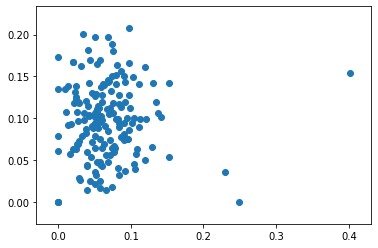

In [16]:
plt.scatter(df['neg'], df['pos'])

In [17]:
arr = df['content'].str.lower().str.replace(r'[.?!]', '').str.split().to_numpy()

In [18]:
word = np.array([i for sub in arr for i in sub])

In [19]:
len(set(word))

3806

In [20]:
len(word)

39655

In [21]:
set(word[:10])

{'am', 'hello', 'how', 'i', 'making', 'should', 'start', 'umm,', 'well'}

In [22]:
df['clean_content'] = df['content'].str.lower().str.replace(r'[.?!]', '')

In [23]:
df.loc[:, 'neg':'pos']

,neg,neu,pos
0,0.050,0.871,0.079
1,0.069,0.787,0.144
2,0.141,0.757,0.102
3,0.095,0.805,0.100
4,0.107,0.835,0.058
...,...,...,...
169,0.044,0.785,0.170
170,0.041,0.778,0.182
171,0.077,0.863,0.060
172,0.080,0.780,0.141


In [24]:
df['isNeg'] = df['neg'] > df['pos']
df['isNeg'] = df['isNeg'].astype(int)

In [25]:
neg_messages = df[df['isNeg'] == 1]

In [26]:
df.iloc[np.argmax(neg_messages['neg'])]

/home/shershah/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


_id                                       5d2f75471c9d4400005b2a90
title                                                     Fighting
date                                                     6/12/2019
startTime                                                  4:27 PM
endTime                                                    4:28 PM
content          It has been a hard few days. Dad has been acti...
neg                                                          0.401
neu                                                          0.445
pos                                                          0.154
clean_content    it has been a hard few days dad has been actin...
isNeg                                                            1
Name: 143, dtype: object

In [27]:
df.iloc[np.argmin(neg_messages['neg'])]

/home/shershah/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


_id                                       5d2f600a1c9d4400005b2a44
title                                                  I am sleepy
date                                                      12/28/18
startTime                                                 11:27 PM
endTime                                                   11:31 PM
content          I am realy sleepy right now. I don't know why....
neg                                                           0.03
neu                                                          0.943
pos                                                          0.027
clean_content    i am realy sleepy right now i don't know why i...
isNeg                                                            1
Name: 67, dtype: object

In [28]:
pos_messages = df[df['isNeg'] == 0]

In [29]:
len(neg_messages), len(pos_messages)

(51, 123)

In [30]:
np.mean([len(x) for x in df['content'].str.split()])

227.9022988505747

In [3]:
dum = pd.DataFrame([[4, 9]] * 3, columns=['A', 'B'])

In [4]:
dum

,A,B
0,4,9
1,4,9
2,4,9


In [7]:
dum.apply(lambda x: x['A'], axis=1)

0    4
1    4
2    4
dtype: int64

# VADER

# Bag of Words

# N-Gram

# Word2Vec

# Transformer Models